<h1>Analysis of Bilbo C2 chip: IV curves</h1>
Online analysis script used to pre-analyse the data collected during the cooldown of the chip.

In [4]:
sample_name = 'bilbo_c2'                    # name of the chip in the fridge
date_suffixe = '20221116'
user = 'sc-ncr'                               # who is performing measurements

<h3>Basic imports and database loading</h3>

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
from resonator_tools import circuit

import qcodes as qc
from qcodes import initialise_database, load_by_run_spec
from qcodes.dataset.plotting import plot_by_id

import scipy.optimize
import scipy.ndimage
import tqdm.notebook as tqdm

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [6]:
db_name = 'iv_curves.db'   # name of the database
db_path  = os.path.join(r'D:\QMET' + '\\' + sample_name + '\\',date_suffixe+'_'+user+'_'+ db_name)

qc.initialise_or_create_database_at(db_path)

OperationalError: unable to open database file

<h2>Data analysis and plotting</h2>

<h4>IV of the Bloch array as a function of the applied flux</h4>

In [7]:
# loading
RUN_ID = 6
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
ivf_dict = dataset.to_pandas_dataframe_dict()

<h5>Data shaping</h5>

In [8]:
# up ramp
ivf_up_0 = ivf_dict['adwin_up_ramp']
ivf_up_1 = ivf_up_0.reset_index()

Ib_up = ivf_up_1['current_source_current'].to_numpy()
v_up = ivf_up_1['adwin_input_2_voltage_up'].to_numpy()
i_up = ivf_up_1['adwin_up_ramp'].to_numpy()

# down ramp
ivf_down_0 = ivf_dict['adwin_down_ramp']
ivf_down_1 = ivf_down_0.reset_index()

Ib_down = ivf_down_1['current_source_current'].to_numpy()
v_down = ivf_down_1['adwin_input_2_voltage_down'].to_numpy()
i_down = ivf_down_1['adwin_down_ramp'].to_numpy()

# reshape to form a 2D array
if RUN_ID == 4:
    N = 20000
if RUN_ID == 38:
    N = 25234
if RUN_ID == 45:
    N = 11998    
N = np.unique(Ib_up).shape[0]

size = (N, -1)

Ib_up = np.reshape(Ib_up, size)
v_up = np.reshape(v_up, size)
i_up = np.reshape(i_up, size)
Ib_down = np.reshape(Ib_down, size)
v_down = np.reshape(v_down, size)
i_down = np.reshape(i_down, size)

# # divide into low-to-high and high-to-low
# M = len(i_up)
# zero_index_up = np.argmin(np.abs(i_up[51]))
# zero_index_down = np.argmin(np.abs(i_down[51]))

# v_lh = np.zeros((M, 2*N - zero_index_down - zero_index_up))
# v_hl = np.zeros((M, zero_index_down + zero_index_up))
# i_lh = np.zeros((M, 2*N - zero_index_down - zero_index_up))
# i_hl = np.zeros((M, zero_index_down + zero_index_up))

# for i in range(M):
#     v_lh[i] = np.concatenate(( np.flip(v_down[i][zero_index_down:]), v_up[i][zero_index_up:] ))
#     v_hl[i] = np.concatenate(( v_up[i][:zero_index_up], np.flip(v_down[i][:zero_index_down]) ))
#     i_lh[i] = np.concatenate(( np.flip(i_down[i][zero_index_down:]), i_up[i][zero_index_up:] ))
#     i_hl[i] = np.concatenate(( i_up[i][:zero_index_up], np.flip(i_down[i][:zero_index_down]) ))

<h5>Plotting</h5>

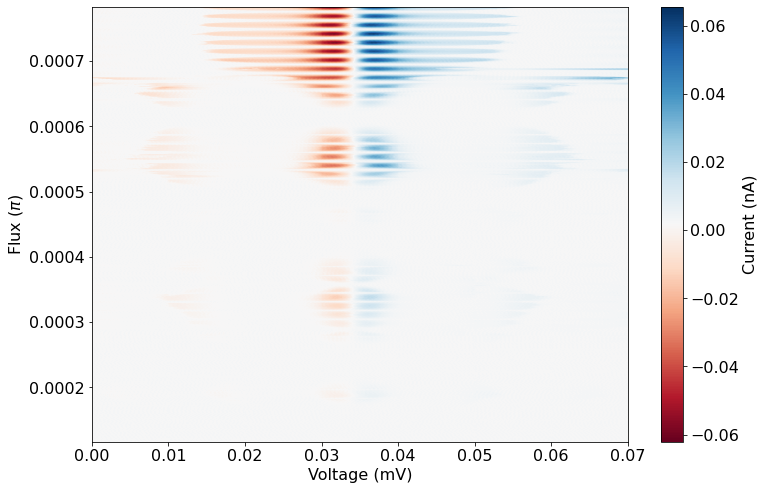

In [11]:
# plotting
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(12,8))
voltage_scaling = 1
voltage_offset = 0.45e-3
current_scaling = 1e9

plt.imshow(current_scaling*i_up, aspect='auto', 
           extent=[np.min(Ib_up[:, 0]), np.max(Ib_up[:,0]) , voltage_scaling*(np.min(v_up[0, :]) + voltage_offset), voltage_scaling*(np.max(v_up[0, :]) + voltage_offset)], 
           cmap='RdBu')
plt.xlabel('Voltage (mV)')
plt.ylabel('Flux ($\pi$)')
plt.colorbar(label='Current (nA)')

# plt.hlines(-1, -5, 5, linestyles='dashed', colors='black', alpha=0.5)
# plt.hlines(0, -5, 5, linestyles='dashed', colors='black', alpha=0.5)

In [17]:
fi_up = scipy.ndimage.uniform_filter1d(i_up, size=30, axis=1)
fv_up = scipy.ndimage.uniform_filter1d(v_up, size=30, axis=1)

Text(0, 0.5, 'I')

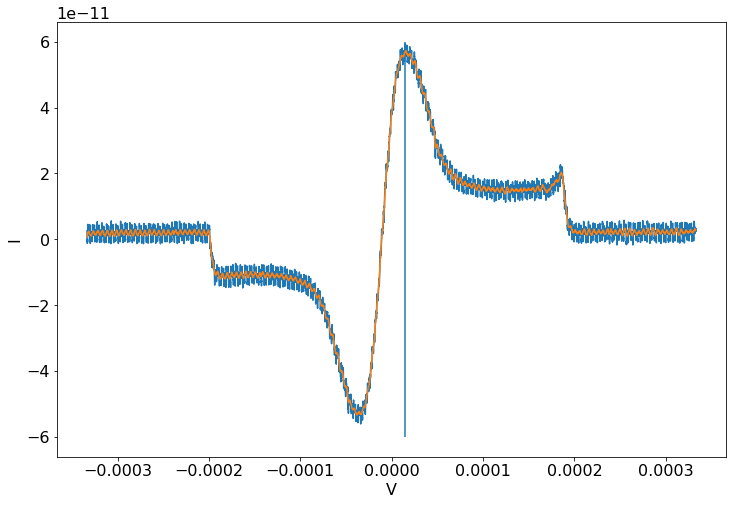

In [24]:

plt.figure(figsize=(12,8))
plt.plot(v_up[0, :], i_up[0, :])
plt.plot(fv_up[0, :], fi_up[0, :])

plt.vlines( [fv_up[0, 5500]],-6e-11 , 6e-11)

plt.xlabel("V")
plt.ylabel("I")
# plt.savefig("smallV_iv.png")

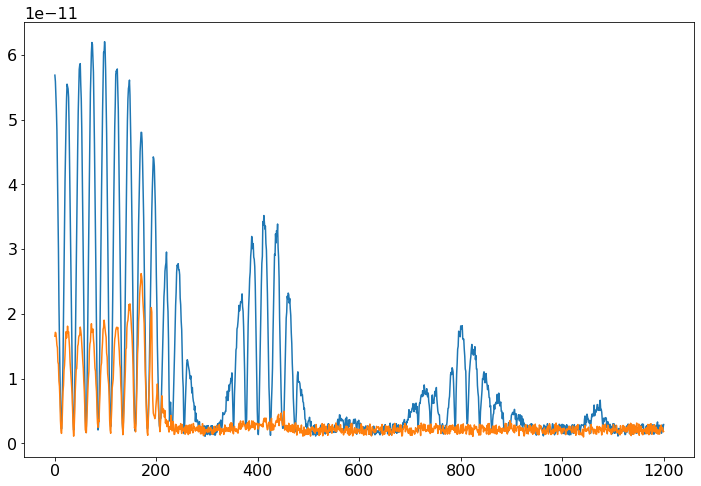

In [30]:

plt.figure(figsize=(12,8))
plt.plot(fi_up[:, 5500])
plt.plot(fi_up[:, 6500])

<h4>VNA trace as function of the DC bias, with superimposed IV curve</h4>

In [33]:
# loading vna data
date_suffixe = '20221003'
db_name = 's21_meas.db'   # name of the database
db_path  = os.path.join(r'D:\QMET' + '\\' + sample_name + '\\',date_suffixe+'_'+user+'_'+ db_name)

qc.initialise_or_create_database_at(db_path)

RUN_ID = 8
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
vnadc_vna_dict = dataset.to_pandas_dataframe_dict()
#loading IV data
date_suffixe = '20221004'
db_name = 'iv_curves.db'   # name of the database
db_path  = os.path.join(r'D:\QMET' + '\\' + sample_name + '\\',date_suffixe+'_'+user+'_'+ db_name)

qc.initialise_or_create_database_at(db_path)

RUN_ID = 1
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
vnadc_dc_dict = dataset.to_pandas_dataframe_dict()

<h5>Data shaping</h5>

In [34]:
# IV curve
vnadc_dc_up_0 = vnadc_dc_dict['adwin_up_ramp']
vnadc_dc_up_1 = vnadc_dc_up_0.reset_index()
v_up = vnadc_dc_up_1['adwin_input_2_voltage_up'].to_numpy()
i_up = vnadc_dc_up_1['adwin_up_ramp'].to_numpy()

# down ramp
vnadc_dc_down_0 = vnadc_dc_dict['adwin_down_ramp']
vnadc_dc_down_1 = vnadc_dc_down_0.reset_index()
v_down = vnadc_dc_down_1['adwin_input_2_voltage_down'].to_numpy()
i_down = vnadc_dc_down_1['adwin_down_ramp'].to_numpy()

# divide into low-to-high and high-to-low
N = len(v_up)
zero_index_up = np.argmin(np.abs(i_up))
zero_index_down = np.argmin(np.abs(i_down))

v_dc_lh = np.concatenate(( np.flip(v_down[zero_index_down:]), v_up[zero_index_up:] ))
i_dc_lh = np.concatenate(( np.flip(i_down[zero_index_down:]), i_up[zero_index_up:] ))
v_dc_hl = np.concatenate(( v_up[:zero_index_up], np.flip(v_down[:zero_index_down]) ))
i_dc_hl = np.concatenate(( i_up[:zero_index_up], np.flip(i_down[:zero_index_down]) ))

# VNA spectra
vnadc_vna_0 = vnadc_vna_dict['ZNB20_S21_magnitude']
vnadc_vna_1 = vnadc_vna_0.reset_index()

frq = vnadc_vna_1['ZNB20_S21_S21_frequency'].to_numpy()
v_bias = vnadc_vna_1['adwin_output1'].to_numpy()
mag = vnadc_vna_1['ZNB20_S21_magnitude'].to_numpy()

m_size = (-1, np.unique(frq).size)
frq = np.reshape(frq, m_size)
v_bias = np.reshape(v_bias, m_size)
mag = np.reshape(mag, m_size)

<h5>Plotting</h5>

In [35]:
frq.shape

(201, 4001)

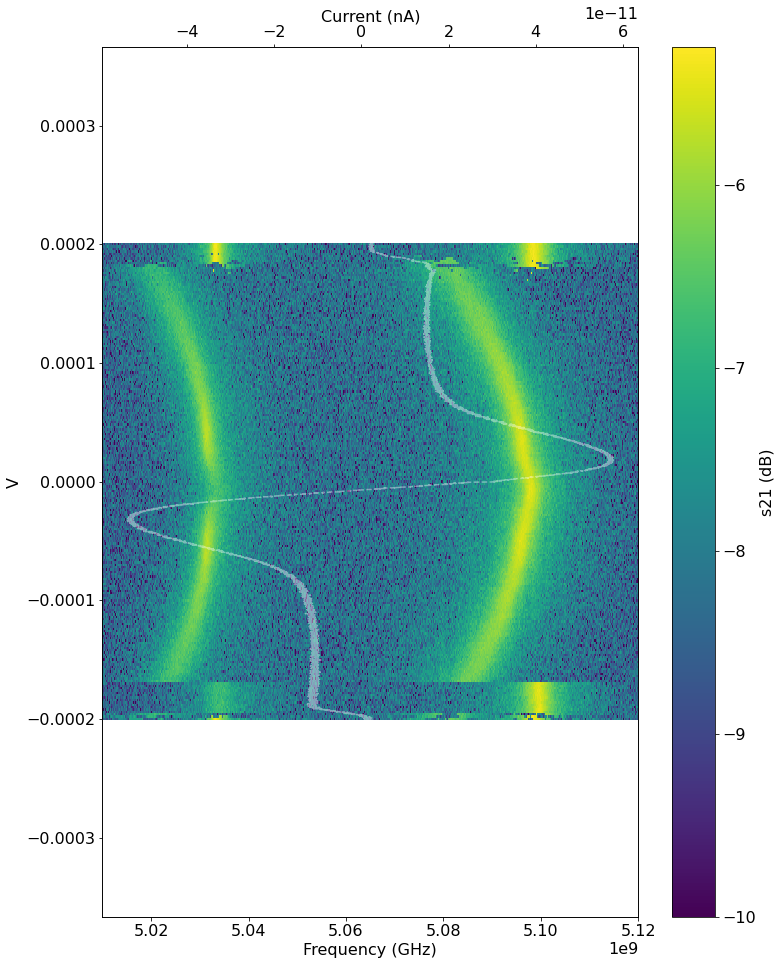

In [44]:
fig, ax1 = plt.subplots(figsize=(12,16))
voltage_scaling = 1e0
voltage_offset = -0.00
current_scaling = 1e0

ctf = ax1.pcolormesh(frq[:, :], v_bias[:, :], np.log(mag[:, :]), shading='nearest', vmin=-10)
fig.colorbar(ctf, label='s21 (dB)')
ax1.set_ylabel('V')
ax1.set_xlabel('Frequency (GHz)')
# ax1.set_ylim([0,5])
# ax1.set_ylim([-10,0])

ax2 =ax1.twiny()
ax2.plot(current_scaling*i_up, voltage_scaling*v_up - voltage_offset, 'w--', alpha=0.4)
ax2.set_xlabel('Current (nA)');

# plt.savefig('s21_dc.jpg')

<h4>VNA trace as function of the DC bias vs Flux</h4>

In [4]:
# loading vna data
RUN_ID = 31
dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
vnadc_vna_dict = dataset.to_pandas_dataframe_dict()
# #loading IV data
# RUN_ID = 23
# dataset = qc.load_by_run_spec(captured_run_id=RUN_ID)
# vnadc_dc_dict = dataset.to_pandas_dataframe_dict()

NameError: No run matching the supplied information found.

<h5>Data shaping</h5>

In [1]:
# IV curve
# vnadc_dc_up_0 = vnadc_dc_dict['adwin_up_ramp']
# vnadc_dc_up_1 = vnadc_dc_up_0.reset_index()
# v_up = vnadc_dc_up_1['adwin_input_2_voltage_up'].to_numpy()
# i_up = vnadc_dc_up_1['adwin_up_ramp'].to_numpy()

# # down ramp
# vnadc_dc_down_0 = vnadc_dc_dict['adwin_down_ramp']
# vnadc_dc_down_1 = vnadc_dc_down_0.reset_index()
# v_down = vnadc_dc_down_1['adwin_input_2_voltage_down'].to_numpy()
# i_down = vnadc_dc_down_1['adwin_down_ramp'].to_numpy()

# # divide into low-to-high and high-to-low
# N = len(v_up)
# zero_index_up = np.argmin(np.abs(i_up))
# zero_index_down = np.argmin(np.abs(i_down))

# v_dc_lh = np.concatenate(( np.flip(v_down[zero_index_down:]), v_up[zero_index_up:] ))
# i_dc_lh = np.concatenate(( np.flip(i_down[zero_index_down:]), i_up[zero_index_up:] ))
# v_dc_hl = np.concatenate(( v_up[:zero_index_up], np.flip(v_down[:zero_index_down]) ))
# i_dc_hl = np.concatenate(( i_up[:zero_index_up], np.flip(i_down[:zero_index_down]) ))

# VNA spectra
vnadc_vna_0 = vnadc_vna_dict['ZNB20_S21_magnitude']
vnadc_vna_1 = vnadc_vna_0.reset_index()

frq = vnadc_vna_1['ZNB20_S21_S21_frequency'].to_numpy()
v_bias = vnadc_vna_1['adwin_output1'].to_numpy()
mag = vnadc_vna_1['ZNB20_S21_magnitude'].to_numpy()
Ib = vnadc_vna_1['current_source_current'].to_numpy()

freq_size =  np.unique(frq).size
current_size = np.unique(Ib).size
m_size = (current_size, -1, freq_size)
frq = np.reshape(frq, m_size)
v_bias = np.reshape(v_bias, m_size)
mag = np.reshape(mag, m_size)

NameError: name 'vnadc_vna_dict' is not defined

In [67]:
np.unique(Ib)

array([-0.005 , -0.0048, -0.0046, -0.0044, -0.0042, -0.004 , -0.0038,
       -0.0036, -0.0034, -0.0032, -0.003 , -0.0028, -0.0026, -0.0024,
       -0.0022, -0.002 , -0.0018, -0.0016, -0.0014, -0.0012, -0.001 ,
       -0.0008, -0.0006, -0.0004, -0.0002,  0.    ,  0.0002,  0.0004,
        0.0006,  0.0008,  0.001 ,  0.0012,  0.0014,  0.0016,  0.0018,
        0.002 ,  0.0022,  0.0024,  0.0026,  0.0028,  0.003 ,  0.0032,
        0.0034,  0.0036,  0.0038,  0.004 ,  0.0042,  0.0044,  0.0046,
        0.0048,  0.005 ])

In [ ]:
current_idx = current_size//2 -10

fig, ax1 = plt.subplots(figsize=(12,16))
voltage_scaling = 1e3
voltage_offset = -0.035
current_scaling = 1e9

ctf = ax1.pcolormesh(frq[current_idx, :, :800], v_bias[current_idx, :, :800], np.log(mag[current_idx, :, :800]), shading='nearest')
fig.colorbar(ctf, label='s21 (dB)')
ax1.set_ylabel('V')
ax1.set_xlabel('Frequency (GHz)')
# ax1.set_ylim([0,5])
# ax1.set_ylim([-10,0])

# ax2 =ax1.twiny()
# ax2.plot(current_scaling*np.abs(i_up), voltage_scaling*v_up - voltage_offset, 'w--', alpha=0.4)
# ax2.set_xlabel('Current (nA)');

# plt.savefig('s21_dc.png')

Text(0.5, 0, 'Frequency (GHz)')

<h5>Data shaping</h5>

In [6]:
# IV
# up ramp
ivf_up_0 = ivf_dict['adwin_up_ramp']
ivf_up_1 = ivf_up_0.reset_index()
v_up = ivf_up_1['adwin_input_2_voltage_up'].to_numpy()
i_up = ivf_up_1['adwin_up_ramp'].to_numpy()

i_flux_up = ivf_up_1['current_source_current'].to_numpy()

# down ramp
ivf_down_0 = ivf_dict['adwin_down_ramp']
ivf_down_1 = ivf_down_0.reset_index()
v_down = ivf_down_1['adwin_input_2_voltage_down'].to_numpy()
i_down = ivf_down_1['adwin_down_ramp'].to_numpy()

i_flux_down = ivf_down_1['current_source_current'].to_numpy()


In [7]:
N = np.unique(i_flux_up).shape[0]
size = (N,-1)

v_up = np.reshape(v_up,size)
i_up = np.reshape(i_up, size)
i_flux_up = np.reshape(i_flux_up, size)


In [8]:
N

101